# Libraries

In [1]:
import requests

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
import re
import math

#import dtale 

pd.set_option('display.max_columns', None) # display all columns in DF
pd.set_option('display.max_rows', None) 

# Color Palette

The colors are used in the following figures.

In [3]:
pal = sns.color_palette("Set2")
pal.as_hex()
print(pal)

[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), (0.6509803921568628, 0.8470588235294118, 0.32941176470588235), (1.0, 0.8509803921568627, 0.1843137254901961), (0.8980392156862745, 0.7686274509803922, 0.5803921568627451), (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]


# Describing the data

In [41]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])
print('Total number of observations: ', len(df))
print('Total number of unique drugs: ', df['unique_id'].nunique())
print('Total number of unique brand name producers: ', df['labeler_name'].nunique())
print('Total number of unique generic producers: ', df['generic_name'].nunique())

Total number of observations:  135076
Total number of unique drugs:  1005
Total number of unique brand name producers:  289
Total number of unique generic producers:  391


In [44]:
df['producer_type'] = df['labeler_name_count'].apply(lambda x: 'Brand name producer' if x == 1 else 'Generic producer')
df['pre_post_event'] = df['running_count_event'].apply(lambda x: 'Pre-event' if x < 0 else 'Post-event')

print('Total number of observations for brand name drug pre-event: ', len(df[(df['producer_type'] == 'Brand name producer') & (df['pre_post_event'] == 'Pre-event')]))
print('Total number of observations for brand name drug post-event: ', len(df[(df['producer_type'] == 'Brand name producer') & (df['pre_post_event'] == 'Post-event')]))
print('Total number of observations for generic drug post-event: ', len(df[(df['producer_type'] == 'Generic producer') & (df['pre_post_event'] == 'Post-event')]))

Total number of observations for brand name drug pre-event:  36820
Total number of observations for brand name drug post-event:  23776
Total number of observations for generic drug post-event:  74480


# Figure: Number of producers and avg. log price per unit

Import data

In [3]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Creating a variable for producer type

In [4]:
df_temp = df

df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand name producer' if x == 1 else 'Generic producer')

Calculating the avg. price grouped by the number of producers

In [5]:
df_temp = df_temp.groupby(['producer_type', 'running_count_generics', 'unique_id'], as_index = False)['price_per_unit_adj'].mean()

df_temp['running_count_generics'] = df_temp['running_count_generics'] + 1
df_temp['ln_price_per_unit_adj'] = np.log(df_temp['price_per_unit_adj'])

df_temp['ln_price_per_unit_adj_demeaning'] = df_temp['ln_price_per_unit_adj'].sub(df_temp['ln_price_per_unit_adj'].mean())

Plotting the figure

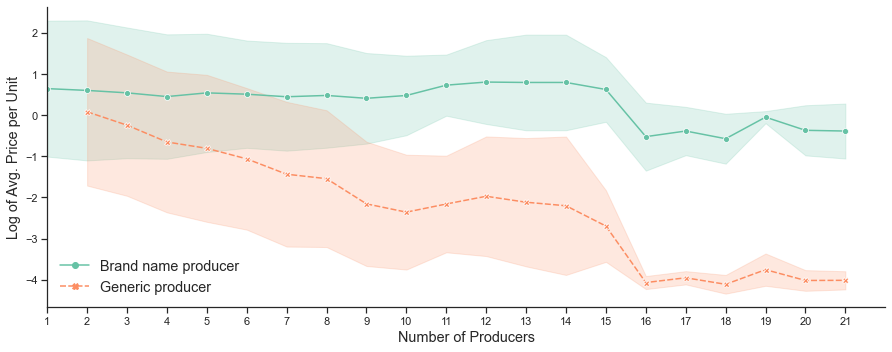

In [15]:
x = df_temp['running_count_generics'].max() # length of x-axis

fig = sns.relplot(data = df_temp, kind = 'line',
                  x = 'running_count_generics', y= 'ln_price_per_unit_adj_demeaning',
                  hue = 'producer_type', style = 'producer_type', ci = 'sd', markers = True, facet_kws={'legend_out': False},
                  height = 5, aspect = 2.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style = 'ticks', palette = 'Set2', rc=custom_params)

#plt.title('Price dynamics in the face of increasing competition')
plt.xlabel('Number of Producers', fontsize = 'large')
plt.ylabel('Log of Avg. Price per Unit', fontsize = 'large')
plt.legend(loc = 'lower left', frameon = False, fontsize = 'large')
plt.xticks(np.arange(1, x + 1, 1))

plt.rcParams["axes.edgecolor"] = "black"

plt.xlim(left = 1)

plt.savefig('Log of Avg. Price per Unit for an increasing number of generic producers.png', bbox_inches = 'tight')
plt.show()

# Figure: Number of producers after first generic entrance

Import data

In [71]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Creating a variable for producer type

In [72]:
df_temp = df

df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand name producer' if x == 1 else 'Generic producer')

Change the Time Event

In [73]:
df_temp = df_temp[df_temp['running_count_event'] >= 0]

Calculating the number of producers split between brand-name and genenic producers along with the avg. number of producers per unique drug

In [75]:
df_temp = df_temp.groupby(['running_count_event', 'producer_type'], as_index = False)[['labeler_name']].count()

df_temp = df_temp.pivot(index = 'running_count_event', columns = 'producer_type', values = ['labeler_name'])
df_temp = df_temp.droplevel(level = 1, axis = 1)
df_temp = df_temp.reset_index()
df_temp.columns = ['running_count_event','number_of_brand_name_producers','number_of_generic_producers']

df_temp['average_number_of_producers'] = (df_temp['number_of_generic_producers'] + df_temp['number_of_brand_name_producers']) / df_temp['number_of_brand_name_producers']

Plotting the figure

In [76]:
print(df_temp['running_count_event'].max())
print(df_temp['running_count_event'].min())

119.0
0.0


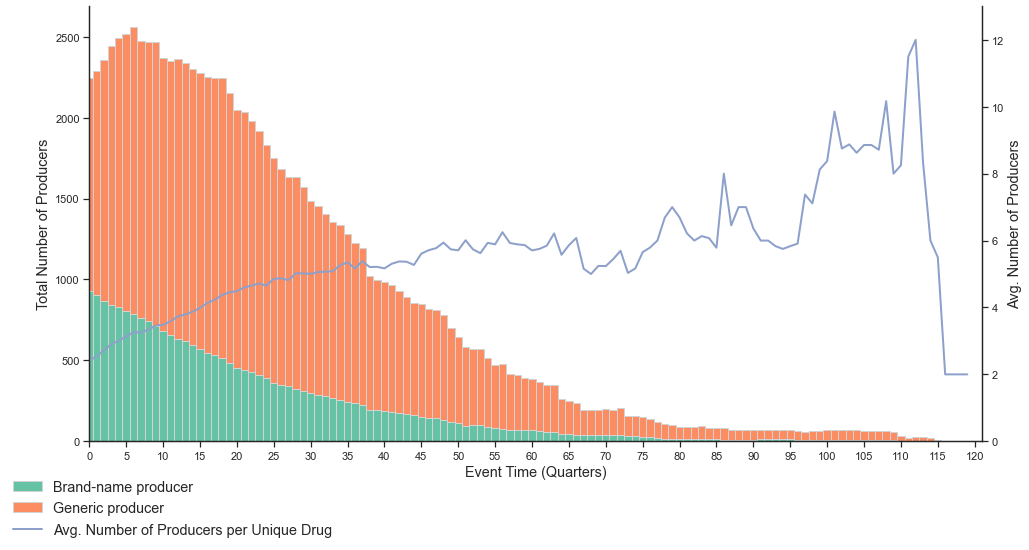

In [77]:
x_axis_max = df_temp['running_count_event'].max() # length of x-axis
x_axis_min = df_temp['running_count_event'].min() # length of x-axis
y = df_temp['average_number_of_producers'].max() # length of 2. y-axis

fig, ax1 = plt.subplots()

fig.set_figwidth(16)
fig.set_figheight(8)

set_width = 1

ax1.bar(df_temp['running_count_event'], df_temp['number_of_brand_name_producers'], label = 'Brand-name producer', color = (0.4, 0.7607843137254902, 0.6470588235294118), edgecolor = 'lightgrey', width = set_width)
ax1.bar(df_temp['running_count_event'], df_temp['number_of_generic_producers'], bottom = df_temp['number_of_brand_name_producers'], label = 'Generic producer', color = (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), edgecolor = 'lightgrey', width = set_width)
ax1.set_ylabel('Total Number of Producers', fontsize = 'large')
plt.legend(bbox_to_anchor = (-0.1, -0.2), loc = 'lower left', frameon = False, fontsize = 'large')
plt.xlabel('Event Time (Quarters)', fontsize = 'large')

ax1 = plt.gca() 
ax2 = ax1.twinx()
ax2.plot(df_temp['running_count_event'], df_temp['average_number_of_producers'], '-', linewidth = 2.0, color = (0.5529411764705883, 0.6274509803921569, 0.796078431372549), label = 'Avg. Number of Producers per Unique Drug')
ax2.set_ylim(0, y + 1)
ax2.set_ylabel('Avg. Number of Producers', fontsize = 'large')
plt.legend(bbox_to_anchor = (-0.1, -0.25), loc = 'lower left', frameon = False, fontsize = 'large')

#plt.title('Number of producers from event')
plt.xticks(np.arange(x_axis_min, x_axis_max + 2, 5))
plt.xlim(left = x_axis_min) # white space
plt.xlim(right = x_axis_max + 2) # white space

plt.savefig('Number of producers over time event.png', bbox_inches = 'tight')
plt.show()

# Figure: Price Dynamics before and after the event

Import data

In [60]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])
#df = df[(df['min_quarter_before_second_entrance'] <= -4) & (df['max_quarter_before_second_entrance'] >= 16)]

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Creating a variable for producer type

In [61]:
df_temp = df

df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand name producer' if x == 1 else 'Generic producer')

Calculating the avg. price split between brand-name and genenic producers

In [62]:
df_temp_price = df_temp.groupby(['running_count_event', 'producer_type', 'unique_id'], as_index = False)['price_per_unit_adj'].mean()

df_temp_price['ln_price_per_unit_adj'] = np.log(df_temp_price['price_per_unit_adj'])

De-meaning the brand name and generic prices

In [63]:
df_temp_price['ln_price_per_unit_adj_demeaning'] = df_temp_price['ln_price_per_unit_adj'].sub(df_temp_price['ln_price_per_unit_adj'].mean())

Calculating the total quantity split between brand-name and genenic producers along with brand-name producers' share

In [64]:
df_temp_quantity = df_temp.groupby(['running_count_event', 'producer_type'], as_index = False)['units_reimbursed'].sum()

df_temp_quantity = df_temp_quantity.pivot(index = 'running_count_event', columns = 'producer_type', values = 'units_reimbursed')
df_temp_quantity = df_temp_quantity.reset_index()
df_temp_quantity.columns = ['running_count_event', 'units_reimbursed_brand_name_producers','units_reimbursed_generic_producers']

df_temp_quantity['units_reimbursed_generic_producers'] = df_temp_quantity['units_reimbursed_generic_producers'].fillna(0)

df_temp_quantity['units_reimbursed_brand_name_producers_share'] = ((df_temp_quantity['units_reimbursed_brand_name_producers']) / (df_temp_quantity['units_reimbursed_brand_name_producers'] + df_temp_quantity['units_reimbursed_generic_producers'])) * 100

Plotting figure

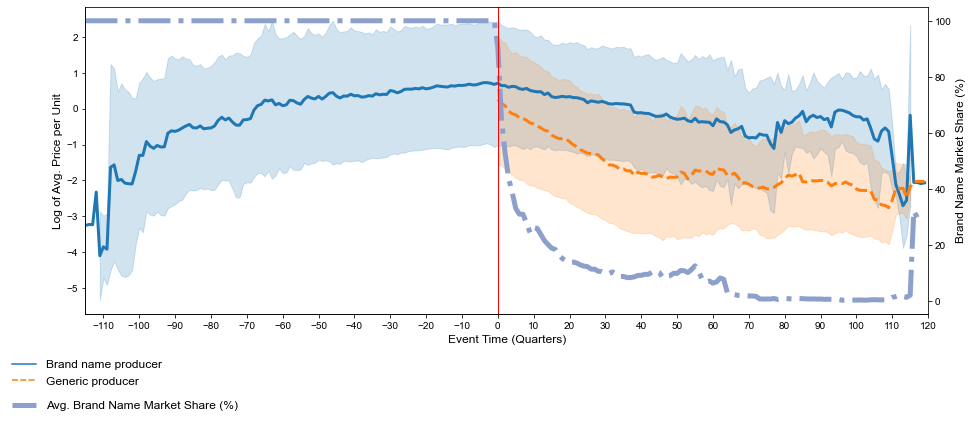

In [65]:
fig = sns.relplot(data = df_temp_price, kind = 'line', # Curves for avg. price
                  x = 'running_count_event', y = 'ln_price_per_unit_adj_demeaning',
                  hue = 'producer_type', style = 'producer_type', linewidth = 3, ci = 'sd', markers = False, facet_kws={'legend_out': False},
                  height = 5, aspect = 2.5)
plt.xlabel('Event Time (Quarters)', fontsize = 'large')
plt.ylabel('Log of Avg. Price per Unit', fontsize = 'large')
plt.legend(bbox_to_anchor = (-0.1, -0.27), loc = 'lower left', frameon = False, fontsize = 'large')
plt.xticks(np.arange(-120, 119 + 6, 10))
plt.xlim(left = -115) # white space
plt.xlim(right = 119 + 1) # white space

fig = plt.twinx() # Curves for total Quantity
fig.plot(df_temp_quantity['running_count_event'], df_temp_quantity['units_reimbursed_brand_name_producers_share'], '-.', linewidth = 5.0, color = (0.5529411764705883, 0.6274509803921569, 0.796078431372549), label = "Avg. Brand Name Market Share (%)")
fig.set_ylabel('Brand Name Market Share (%)', fontsize = 'large')
plt.legend(bbox_to_anchor = (-0.1, -0.35), loc = 'lower left', frameon = False, fontsize = 'large')

custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style = 'ticks', palette = 'Set2', rc=custom_params)

plt.axvline(0, color = "red", lw = 2, ls = '-')

#plt.title('Price dynamics over the event - one generic price')

plt.savefig('Price dynamics over the event - one generic price.png', format = 'png', bbox_inches = 'tight')
plt.show()

# Figure: Price Dynamics before and after the event (more producers)

In [12]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Creating a variable for producer type

In [13]:
df_temp = df
df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand name producer' if x == 1 else 'Generic producer')

Splitting genenic producers based on the timing of entrance

In [14]:
df_temp_price = df_temp

df_temp_price['col_temp'] = 3

df_temp_price['labeler_name_count'] = df_temp_price['labeler_name_count'].astype('int') 
df_temp_price['labeler_name_count'] = df_temp_price['labeler_name_count'] - 1
df_temp_price['labeler_name_count'] = np.where(df_temp_price['labeler_name_count'] > df_temp_price['col_temp'], '3+', df_temp_price['labeler_name_count'])

df_temp_price['producer_type_count'] = df_temp_price['producer_type'].astype(str) + ': ' + df_temp_price['labeler_name_count'].astype(str)

df_temp_price['producer_type_count'] = df_temp_price['producer_type_count'].replace('Brand name producer: 0', 'Brand name producer')

Calculating the avg. price split between brand-name and genenic producers

In [15]:
df_temp_price = df_temp_price.groupby(['running_count_event', 'producer_type_count', 'unique_id'], as_index = False)['price_per_unit_adj'].mean()

df_temp_price['ln_price_per_unit_adj'] = np.log(df_temp_price['price_per_unit_adj'])

df_temp_price['ln_price_per_unit_adj_demeaning'] = df_temp_price['ln_price_per_unit_adj'].sub(df_temp_price['ln_price_per_unit_adj'].mean())

Calculating the total quantity split between brand-name and genenic producers along with brand-name producers' share

In [16]:
df_temp_quantity = df_temp

df_temp_quantity = df_temp_quantity.groupby(['running_count_event', 'producer_type'], as_index = False)['units_reimbursed'].sum()

df_temp_quantity = df_temp_quantity.pivot(index = 'running_count_event', columns = 'producer_type', values = 'units_reimbursed')
df_temp_quantity = df_temp_quantity.reset_index()
df_temp_quantity.columns = ['running_count_event', 'units_reimbursed_brand_name_producers','units_reimbursed_generic_producers']

df_temp_quantity['units_reimbursed_generic_producers'] = df_temp_quantity['units_reimbursed_generic_producers'].fillna(0)

df_temp_quantity['units_reimbursed_brand_name_producers_share'] = ((df_temp_quantity['units_reimbursed_brand_name_producers']) / (df_temp_quantity['units_reimbursed_brand_name_producers'] + df_temp_quantity['units_reimbursed_generic_producers'])) * 100

Plotting figure

In [17]:
print(df_temp_price['running_count_event'].max())
print(df_temp_price['running_count_event'].min())

119.0
-115.0


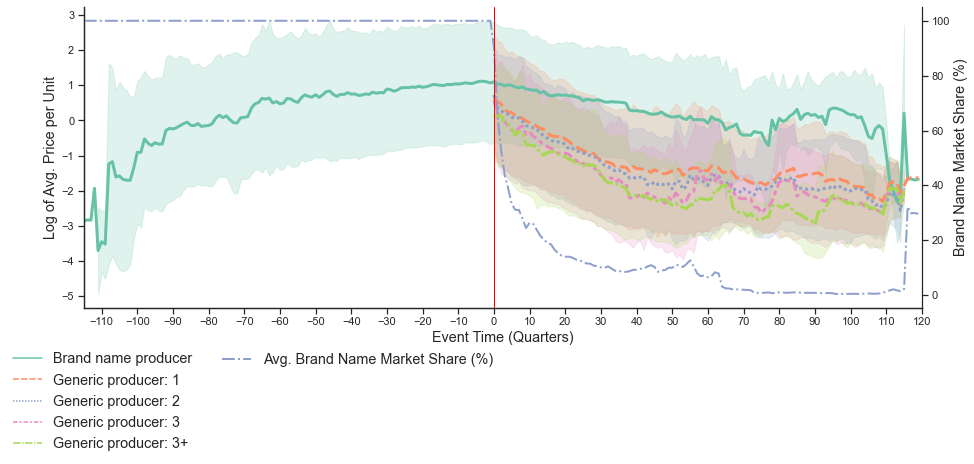

In [24]:
fig = sns.relplot(data = df_temp_price, kind = 'line', # Curves for avg. price
                  x = 'running_count_event', y = 'ln_price_per_unit_adj_demeaning',
                  hue = 'producer_type_count', style = 'producer_type_count', ci = 'sd', linewidth = 3, markers = False, facet_kws={'legend_out': False},
                  height = 5, aspect = 2.5)


plt.xlabel('Event Time (Quarters)', fontsize = 'large')
plt.ylabel('Log of Avg. Price per Unit', fontsize = 'large')
plt.legend(bbox_to_anchor = (-0.1, -0.52), loc = 'lower left', frameon = False, fontsize = 'large')
plt.xticks(np.arange(-120, 119 + 6, 10))
plt.xlim(left = -115) # white space
plt.xlim(right = 119 + 1) # white space

fig = plt.twinx() # Curves for total Quantity
fig.plot(df_temp_quantity['running_count_event'], df_temp_quantity['units_reimbursed_brand_name_producers_share'], '-.', linewidth = 2.0, color = (0.5529411764705883, 0.6274509803921569, 0.796078431372549), label = "Avg. Brand Name Market Share (%)")
fig.set_ylabel('Brand Name Market Share (%)', fontsize = 'large')
plt.legend(bbox_to_anchor = (0.15, -0.24), loc = 'lower left', frameon = False, fontsize = 'large')

custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style = 'ticks', palette = 'Set2', rc=custom_params)

plt.axvline(0, color = "red", lw = 1, ls = '-')

#plt.title('Price dynamics over the event - multiple generic prices')

plt.savefig('Price dynamics over the event - multiple generic prices.png', format = 'png', bbox_inches = 'tight')

plt.show()

# Specific drug figure

Import data

In [81]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Filtering on a specific drug and Time Event

In [82]:
df_temp = df
df_temp = df_temp.loc[df['unique_id'] == "olanzapine-tablet, orally disintegrating-oral-['5 mg/1']"]
df_temp = df_temp[df_temp['running_count_event'] >= -10]
df_temp = df_temp[['date', 'generic_name', 'labeler_name', 'price_per_unit_adj']]

Removing "," and "."

In [83]:
df_temp['labeler_name'] = df_temp['labeler_name'].apply(lambda x: x.replace(',', ''))
df_temp['labeler_name'] = df_temp['labeler_name'].apply(lambda x: x.replace('.', ''))

Change the format of datem

In [84]:
df_temp['date'] = pd.to_datetime(df_temp['date'])

Creating the data for price

In [85]:
df_temp['ln_price_per_unit_adj'] = np.log(df_temp['price_per_unit_adj'])

Plotting the figure

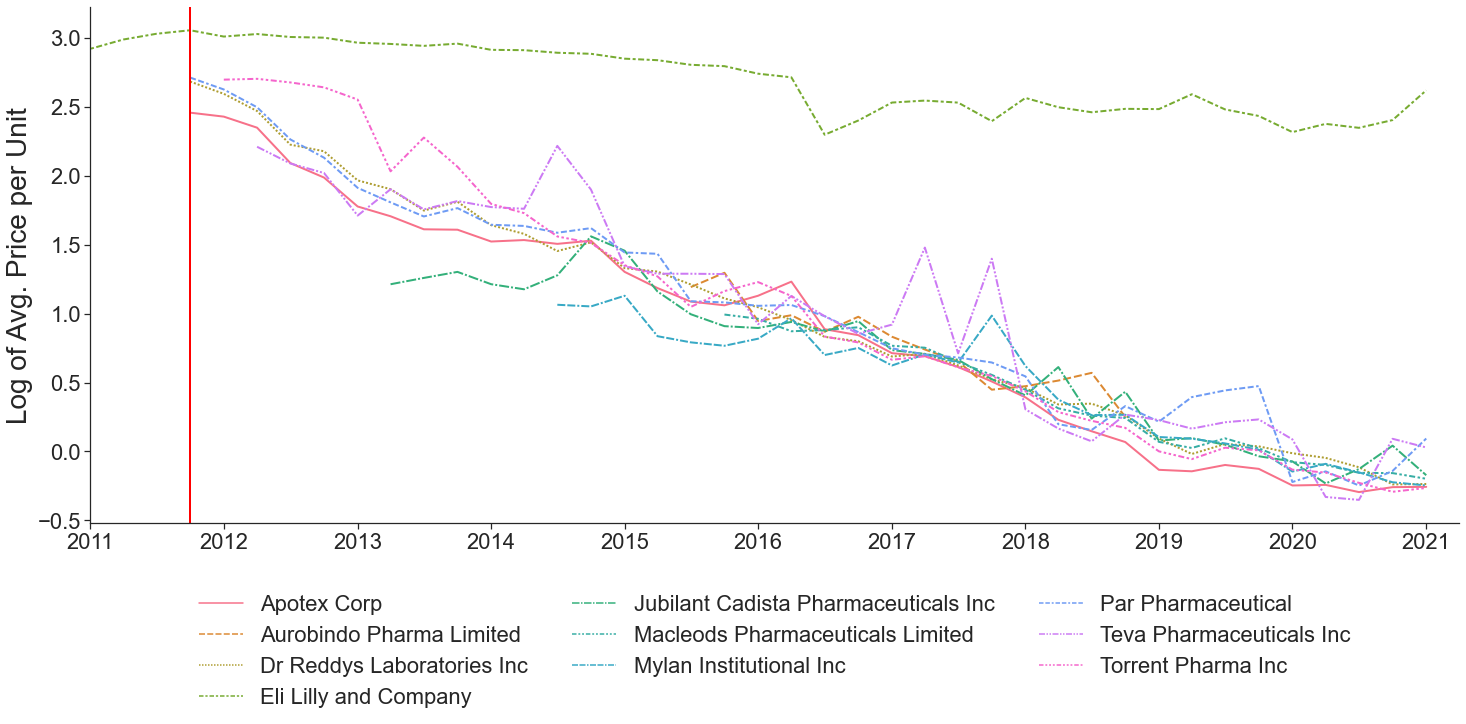

In [86]:
fig = sns.relplot(data = df_temp, kind = 'line', # Curves for avg. price
                  x = 'date', y= 'ln_price_per_unit_adj',
                  hue = 'labeler_name', style = 'labeler_name', linewidth = 2, markers = False, facet_kws={'legend_out': False},
                  height = 8, aspect = 2.5)

plt.xlabel('', fontsize = 1)
plt.ylabel('Log of Avg. Price per Unit', fontsize = 28)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1), frameon = False, fontsize = 22, ncol = 3) # (-0.06, -0.45)
plt.tick_params(axis='both', labelsize = 22)

custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style = 'ticks', palette = 'Set2', rc = custom_params)

plt.xlim(left = pd.Timestamp('01-01-2011')) # white space
plt.xlim(right = pd.Timestamp('04-01-2021')) # white space

plt.axvline(pd.Timestamp('10-01-2011'), color = "red", lw = 2, ls = '-')

#plt.title('Price dynamics over the time for Olanzapine (Zyprexa) - an antipsychotic drug')

plt.savefig('Price dynamics over the time for Olanzapine (Zyprexa) - an antipsychotic drug.png', format = 'png', bbox_inches = 'tight')

plt.show()

Making a similar figiure for capecitabine

In [98]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


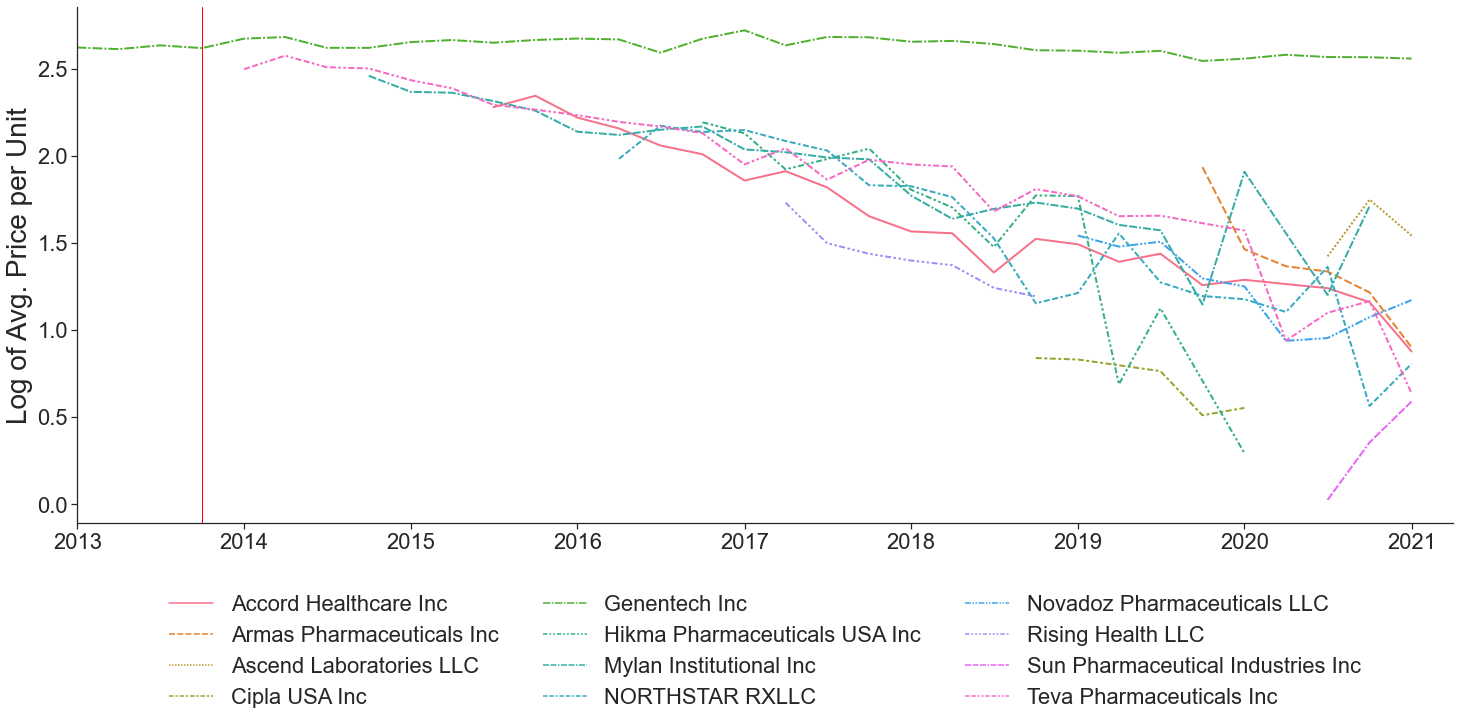

In [99]:
df_temp = df
df_temp = df_temp.loc[df['unique_id'] == "capecitabine-tablet, film coated-oral-['150 mg/1']"]
df_temp = df_temp[df_temp['running_count_event'] >= -10]
df_temp = df_temp[['date', 'generic_name', 'labeler_name', 'price_per_unit_adj']]

df_temp['labeler_name'] = df_temp['labeler_name'].apply(lambda x: x.replace(',', ''))
df_temp['labeler_name'] = df_temp['labeler_name'].apply(lambda x: x.replace('.', ''))

df_temp['date'] = pd.to_datetime(df_temp['date'])

df_temp['ln_price_per_unit_adj'] = np.log(df_temp['price_per_unit_adj'])

fig = sns.relplot(data = df_temp, kind = 'line', # Curves for avg. price
                  x = 'date', y= 'ln_price_per_unit_adj',
                  hue = 'labeler_name', style = 'labeler_name', linewidth = 2, markers = False, facet_kws={'legend_out': False},
                  height = 8, aspect = 2.5)

plt.xlabel('', fontsize = 1)
plt.ylabel('Log of Avg. Price per Unit', fontsize = 28)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1), frameon = False, fontsize = 22, ncol = 3) # (-0.06, -0.45)
plt.tick_params(axis='both', labelsize = 22)

custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style = 'ticks', palette = 'Set2', rc = custom_params)

plt.xlim(left = pd.Timestamp('01-01-2013')) # white space
plt.xlim(right = pd.Timestamp('04-01-2021')) # white space

plt.axvline(pd.Timestamp('10-01-2013'), color = "red", lw = 1, ls = '-')

#plt.title('Price dynamics over the time for Olanzapine (Zyprexa) - an antipsychotic drug')

plt.savefig('Price dynamics over the time for Capecitabine (Xeloda) - an cancer drug.png', format = 'png', bbox_inches = 'tight')

plt.show()

# Descriptive table

### For price and quantity

Importing data

In [20]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])
#df = df[(df['running_count_event'] >= -4) & (df['running_count_event'] <= 40)]

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Creating a variable for producer type along with pre- and post generic entrance

In [21]:
df['producer_type'] = df['labeler_name_count'].apply(lambda x: 'Brand name producer' if x == 1 else 'Generic producer')
#df['producer_type'] = df['marketing_category'].apply(lambda x: 'Brand name producer' if x == "NDA" else 'Generic producer')

df['pre_post_event'] = df['running_count_event'].apply(lambda x: 'Pre-event' if x < 0 else 'Post-event')

Calculating the avg. price and total quantity split between brand name and generic producers

In [22]:
df_p = df.groupby(['unique_id', 'date', 'pre_post_event', 'producer_type'], as_index = False)['price_per_unit_adj'].mean()
df_q = df.groupby(['unique_id', 'date', 'pre_post_event', 'producer_type'], as_index = False)['units_reimbursed'].sum()

df = df_p.merge(df_q, how = 'inner', on = ['unique_id', 'date', 'pre_post_event', 'producer_type'])

df['ln_price_per_unit_adj'] = np.log(df['price_per_unit_adj'])

De-meaning the brand name and generic prices

In [23]:
df['ln_price_per_unit_adj_demeaning'] = df['ln_price_per_unit_adj'].sub(df['ln_price_per_unit_adj'].mean())

Dropping variables

In [24]:
df = df.drop(columns = ['price_per_unit_adj', 'ln_price_per_unit_adj'])

Number of unique drugs

In [25]:
print("Number of drug clusters: ", df[(df['pre_post_event'] == "Pre-event") & (df['producer_type'] == "Brand name producer")].nunique(dropna=True))

Number of drug clusters:  unique_id                           1005
date                                 120
pre_post_event                         1
producer_type                          1
units_reimbursed                   35267
ln_price_per_unit_adj_demeaning    36820
dtype: int64


Pivotting the data

In [26]:
df = df.pivot(index = ['unique_id', 'date'], columns = ['producer_type', 'pre_post_event'])[['ln_price_per_unit_adj_demeaning', 'units_reimbursed']]
df = df.reset_index()

Printing the table

In [27]:
df = df.describe()
df = df.T
df = df.round(2)
df = df.drop(columns = ['count', '25%', '75%'])

In [28]:
df.head(10)

mean  \
                                producer_type       pre_post_event               
ln_price_per_unit_adj_demeaning Brand name producer Pre-event             0.48   
                                                    Post-event            0.30   
                                Generic producer    Post-event           -0.89   
units_reimbursed                Brand name producer Pre-event       3381536.09   
                                                    Post-event       780752.99   
                                Generic producer    Post-event      3858247.28   

                                                                            std  \
                                producer_type       pre_post_event                
ln_price_per_unit_adj_demeaning Brand name producer Pre-event              1.77   
                                                    Post-event             1.61   
                                Generic producer    Post-event             1.81   
units_reimbursed                Brand name producer Pre-event       14130835.13   
                                                    Post-event       4552303.94   
                                Generic producer    Post-event      13012110.49   

                                                                     min  \
                                producer_type       pre_post_event         
ln_price_per_unit_adj_demeaning Brand name producer Pre-event      -9.62   
                                                    Post-event     -9.26   
                                Generic producer    Post-event     -9.07   
units_reimbursed                Brand name producer Pre-event       8.00   
                                                    Post-event      3.28   
                                Generic producer    Post-event      7.64   

                                                                          50%  \
                                producer_type       pre_post_event              
ln_price_per_unit_adj_demeaning Brand name producer Pre-event            0.44   
                                                    Post-event           0.42   
                                Generic producer    Post-event          -1.01   
units_reimbursed                Brand name producer Pre-event       290333.47   
                                                    Post-event       39691.00   
                                Generic producer    Post-event      270511.18   

                                                                             max  
                                producer_type       pre_post_event                
ln_price_per_unit_adj_demeaning Brand name producer Pre-event       9.390000e+00  
                                                    Post-event      7.040000e+00  
                                Generic producer    Post-event      7.190000e+00  
units_reimbursed                Brand name producer Pre-event       1.602508e+09  
                                                    Post-event      1.312277e+08  
                                Generic producer    Post-event      3.178941e+08

Transforming the table to latex

In [29]:
print(df.to_latex(index = True)) 

\begin{tabular}{lllrrrrr}
\toprule
                 &                  &            &        mean &          std &   min &        50\% &           max \\
{} & producer\_type & pre\_post\_event &             &              &       &            &               \\
\midrule
ln\_price\_per\_unit\_adj\_demeaning & Brand name producer & Pre-event &        0.48 &         1.77 & -9.62 &       0.44 &  9.390000e+00 \\
                 &                  & Post-event &        0.30 &         1.61 & -9.26 &       0.42 &  7.040000e+00 \\
                 & Generic producer & Post-event &       -0.89 &         1.81 & -9.07 &      -1.01 &  7.190000e+00 \\
units\_reimbursed & Brand name producer & Pre-event &  3381536.09 &  14130835.13 &  8.00 &  290333.47 &  1.602508e+09 \\
                 &                  & Post-event &   780752.99 &   4552303.94 &  3.28 &   39691.00 &  1.312277e+08 \\
                 & Generic producer & Post-event &  3858247.28 &  13012110.49 &  7.64 &  270511.18 &  3.178941e+08

### For quarter and year

In [55]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])
#df = df[(df['running_count_event'] >= -4) & (df['running_count_event'] <= 40)]

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Selecting year and quarter

In [56]:
df = df[['year', 'quarter']]

Printing the table

In [57]:
df = df.describe()
df = df.T
df = df.round(2)
df = df.drop(columns = ['count', '25%', '75%'])

In [58]:
df.head()

,mean,std,min,50%,max
year,2013.37,6.46,1991.0,2015.0,2021.0
quarter,2.49,1.13,1.0,3.0,4.0


Transforming the table to latex

In [59]:
print(df.to_latex(index = True)) 

\begin{tabular}{lrrrrr}
\toprule
{} &     mean &   std &     min &     50\% &     max \\
\midrule
year    &  2013.37 &  6.46 &  1991.0 &  2015.0 &  2021.0 \\
quarter &     2.49 &  1.13 &     1.0 &     3.0 &     4.0 \\
\bottomrule
\end{tabular}



# Drugs split ATC

Importing data

In [74]:
df_reg = pd.read_csv('output_regression_org.csv', sep = '~')
df_reg = df_reg.dropna(subset = ['running_count_event'])
df_reg = df_reg[(df_reg['min_quarter_before_second_entrance'] <= -4) & (df_reg['max_quarter_before_second_entrance'] >= 16)]

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading the consolidated data for ATC

In [75]:
df_atc = pd.read_csv('raw_consolidation_data_for_ATC_dup.csv', sep = '~')

Merging the transposed and ATC data

In [76]:
df = pd.merge(df_reg, df_atc[['unique_id', 'ATC (level 1)']], on = ['unique_id'], how = 'right')

Grouping the data

In [77]:
df['ln_price_per_unit_adj'] = np.log(df['price_per_unit_adj'])

df['ln_price_per_unit_adj_demeaning'] = df['ln_price_per_unit_adj'].sub(df['ln_price_per_unit_adj'].mean())

In [78]:
df_temp = df.groupby(['ATC (level 1)', 'unique_id'], as_index = False)['ln_price_per_unit_adj_demeaning'].mean()

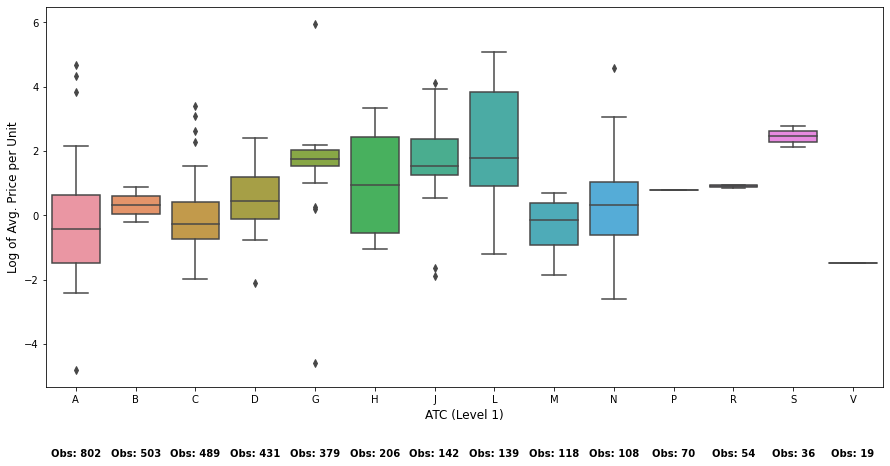

In [84]:
ax, fig = plt.subplots(figsize=[15,7])

ax = sns.boxplot(data = df_temp,
                 x = "ATC (level 1)", y = "ln_price_per_unit_adj_demeaning")

# Calculate number of obs per group & median to position labels
nobs = df_temp['ATC (level 1)'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["Obs: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            - 7.5,
            nobs[tick],
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='semibold')
    
plt.ylabel('Log of Avg. Price per Unit', fontsize = 'large')
plt.xlabel('ATC (Level 1)', fontsize = 'large')

#plt.title('Avg. Price per Unit split between ATC (level 1)')

plt.savefig('Avg. Price per Unit split between ATC (Level 1).png', format = 'png', bbox_inches = 'tight')

plt.show()

In [81]:
df_temp.describe()

,ln_price_per_unit_adj_demeaning
count,358.000000
mean,0.456357
std,1.547145
min,-4.807916
25%,-0.601372
50%,0.404807
75%,1.290966
max,5.938497
